Install and Import Dependencies

In [1]:
!pip install easyocr
!pip install imutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 22.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

Read in Image, Grayscale and Blur

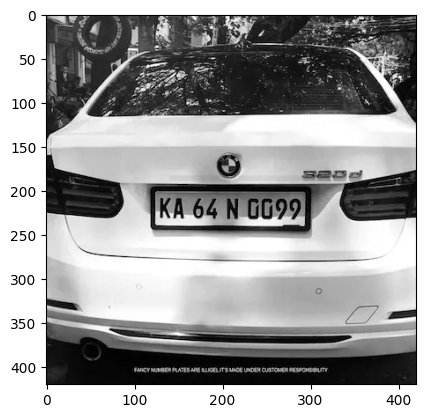

In [19]:
# Read the image
img = cv2.imread('/content/car_img3.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display the grayscale image using matplotlib
plt.imshow(gray, cmap='gray')
plt.show()

Apply filter and find edges for localization

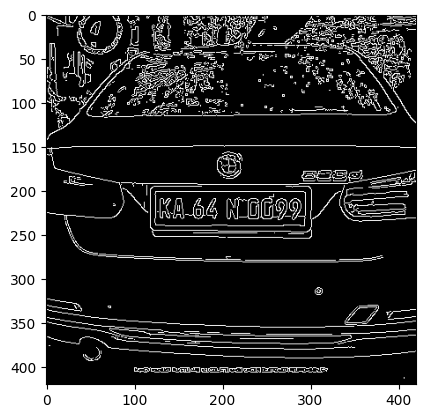

In [20]:
bfilter= cv2.bilateralFilter(gray, 11, 17, 17) #Noise rreduction
edged= cv2.Canny(bfilter, 30, 200) #Edge Detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

Find Contour and Apply Mask

In [21]:
keypoints= cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours= imutils.grab_contours(keypoints)
contours= sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [22]:
location = None
for contour in contours:
  approx = cv2.approxPolyDP(contour, 10, True)
  if len(approx) == 4:
    location = approx
    break

In [23]:
location

array([[[123, 204]],

       [[124, 239]],

       [[293, 240]],

       [[292, 201]]], dtype=int32)

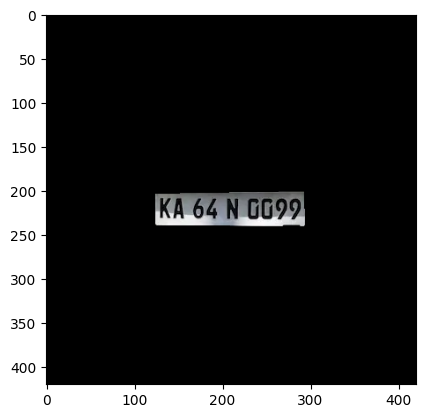

In [27]:
# Find contours in the grayscale image
#contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours are found
if contours:
    # Find the largest contour based on area
    #largest_contour = max(contours, key=cv2.contourArea)
    #location = largest_contour

    # Create a mask with the same shape as the grayscale image, initialized to zeros (black)
    mask = np.zeros(gray.shape, np.uint8)

    # Draw the contour on the mask
    cv2.drawContours(mask, [location], 0, 255, -1)

    # Apply the mask to the original image
    new_image = cv2.bitwise_and(img, img, mask=mask)

    # Display the result using matplotlib
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
else:
    print("No contours found in the image.")


In [28]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

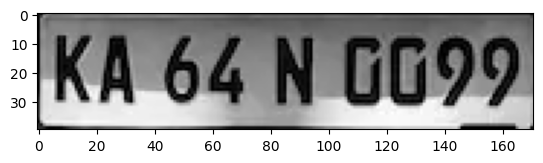

In [29]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

Use Easy OCR to Read Text

In [30]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[([[1, 3], [171, 3], [171, 39], [1, 39]], 'KA 64 N 0099', 0.6099122870722553)]

In [33]:
car_no = result[0][-2]
car_no

'KA 64 N 0099'

Render Result

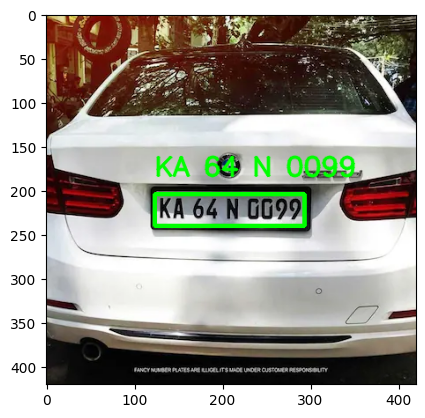

In [34]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img,  text=text, org=(approx[0][0][0], approx[0][0][0]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0), 3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))